###### ETL Process: 
--> Import Python Package 
--> Connect to source database and define destination database in SQL server 
--> read csv file
--> concat existing data and new data
--> populate SQL table

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline
file_path=' '

In [2]:
import pyodbc
import urllib
import sqlalchemy

'''sources databases'''
params_p = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse1;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_p = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_p))


params_s = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse2;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_s = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_s))



'''destination databases'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [3]:
df=pd.read_excel(file_path+'data - Promotional Effectiveness Analysis.xlsx')
df.head()


,Year,week number,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,# Transactions that contained the product
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379


In [4]:
df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       134 non-null    int64  
 1   week number                                134 non-null    int64  
 2   Product                                    134 non-null    object 
 3   Price                                      134 non-null    float64
 4   On Flyer?                                  134 non-null    object 
 5   Discount                                   134 non-null    float64
 6   Units                                      134 non-null    int64  
 7   Sales $                                    134 non-null    float64
 8   Gross Margin $                             134 non-null    float64
 9   # Transactions that contained the product  134 non-null    int64  
dtypes: float64(4), int64(4), o

((134, 10), None)

In [5]:
df.to_sql('retail',engine_datahub,if_exists='replace',index=False)

In [6]:
# drop duplicates - no duplicates
df.drop_duplicates(keep='first', inplace=True)
df.shape

(134, 10)

In [7]:
#check missing values - no missing values
df.isnull().values.any()

False

In [8]:
df_new = df.rename({'# Transactions that contained the product':'Num_Transact','week number':'week'},axis=1)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379


In [9]:
df_new.describe()

,Year,week,Price,Discount,Units,Sales $,Gross Margin $,Num_Transact
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,2021.223881,22.358209,5.381045,0.168657,22475.373134,100484.140299,24477.665632,14527.977612
std,0.418407,15.500377,1.684358,0.175327,16891.686295,50213.865512,10730.292069,5824.488856
min,2021.000000,1.000000,2.490000,0.000000,8381.000000,47484.840000,-23932.000000,8216.000000
25%,2021.000000,9.000000,3.990000,0.000000,9701.000000,66589.775000,22974.742500,9261.250000
50%,2021.000000,19.000000,4.990000,0.150000,13118.000000,73012.860000,24993.375000,12071.000000
75%,2021.000000,35.750000,6.790000,0.300000,32441.750000,131230.107500,32921.070000,21111.000000
max,2022.000000,52.000000,7.990000,0.500000,77200.000000,232605.030000,35631.740000,26439.000000


In [10]:
df_new['Sales/Transact'] = df_new['Sales $']/df_new['Num_Transact']
df_new['Margin/Transact']= df_new['Gross Margin $']/df_new['Num_Transact']
df_new['Cost'] = (df['Sales $']-df['Gross Margin $'])/df['Units']
df_new

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.700000,8460,8.150556,3.968168,4.100000
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.770000,9983,7.436048,3.253909,4.100000
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.520000,17117,6.917586,1.751447,4.100000
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.510000,9038,7.714584,3.491647,4.100000
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.180000,8379,8.069147,3.928533,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2022,11,Aussie,4.29,Yes,0.15,14757,63307.53,22239.353931,12315,5.140685,1.805875,2.782962
130,2022,12,Aussie,4.99,No,0.00,10873,54256.27,23811.870000,10556,5.139851,2.255766,2.800000
131,2022,13,Aussie,4.49,Yes,0.10,12630,56708.70,21339.947228,11254,5.038982,1.896210,2.800376
132,2022,14,Aussie,4.99,No,0.00,10767,53727.33,23579.730000,10556,5.089743,2.233775,2.800000


In [11]:
df_new.groupby('Product')['Sales $'].max()

Product
Aussie     192228.00
Pantene    232605.03
Name: Sales $, dtype: float64

Discount
0.00    28
0.05     3
0.10     1
0.15     7
0.20     3
0.30     7
0.35     2
0.40     5
0.45     3
0.50     8
Name: week, dtype: int64

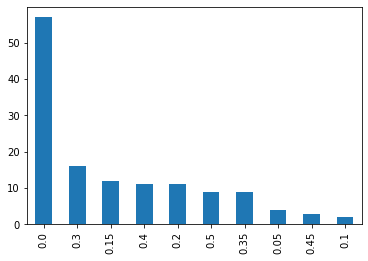

In [12]:
df_new['Discount'].value_counts().plot(kind='bar')
df_Pantene = df_new.query("Product=='Pantene'")
df_Pantene.groupby('Discount')['week'].count()

###### 1.What price point is most effective at maximizing sales?

In [13]:
df_Pantene.loc[df_Pantene['Sales $'].idxmax()]
# 3.99 which is 50% discount of the original price is the most effective price to maximize sales

Year                    2021
week                      12
Product              Pantene
Price                   3.99
On Flyer?                Yes
Discount                 0.5
Units                  58297
Sales $            232605.03
Gross Margin $      -6412.67
Num_Transact           26439
Sales/Transact        8.7978
Margin/Transact    -0.242546
Cost                     4.1
Name: 11, dtype: object

In [14]:
df_Aussie = df_new.query("Product=='Aussie'")
df_Aussie.loc[df_Aussie['Sales $'].idxmax()]
#2.49 which is 50% discount of the original price is the most effective price to maximize sales

Year                   2021
week                     39
Product              Aussie
Price                  2.49
On Flyer?               Yes
Discount                0.5
Units                 77200
Sales $            192228.0
Gross Margin $     -23932.0
Num_Transact          22396
Sales/Transact      8.58314
Margin/Transact   -1.068584
Cost                    2.8
Name: 105, dtype: object

###### 2.What price point is most effective at maximizing gross margin?

In [15]:
df_new.groupby('Product')['Gross Margin $'].max()

Product
Aussie     28248.22
Pantene    35631.74
Name: Gross Margin $, dtype: float64

In [16]:
df_Pantene.loc[df_Pantene['Gross Margin $'].idxmax()]
# 6.79 which is 15% discount of the original price is the most effective price point to maximize gross margin

Year                   2021
week                     35
Product             Pantene
Price                  6.79
On Flyer?               Yes
Discount               0.15
Units                 13246
Sales $            89940.34
Gross Margin $     35631.74
Num_Transact          12130
Sales/Transact     7.414702
Margin/Transact    2.937489
Cost                    4.1
Name: 34, dtype: object

In [17]:
df_Aussie.loc[df_Aussie['Gross Margin $'].idxmax()]
# 3.99 which is 20% discount of the original price is the most effective price point to maximize gross margin

Year                   2021
week                     18
Product              Aussie
Price                  3.99
On Flyer?               Yes
Discount                0.2
Units                 23738
Sales $            94714.62
Gross Margin $     28248.22
Num_Transact          17558
Sales/Transact     5.394385
Margin/Transact    1.608852
Cost                    2.8
Name: 84, dtype: object

###### 3.Is Shampoo seasonal (influenced by time of year)? Explain why or why not.

in this case, num of transactions might be more appropriate to use than sales units because Shampoo has several more brands, 
not only Aussie and Pantene.

step 1: convert week number into day then into month.
    
step 2: reasearch the correlation of discount and number of transactions and look at both trends.
    
If the monthly variation of number of transactions is the same with discount variation, then there is no seasonality.

In [18]:
from datetime import datetime, timedelta
df_new['Year'][0]
df_new['week'][0]
date = str(df_new['Year'][0]) + '-W' + str(df_new['week'][0])
res = datetime.strptime(date + '-1', "%Y-W%W-%w")
res

datetime.datetime(2021, 1, 4, 0, 0)

In [19]:
total_num = len(df_new['Year']) 
period = []
for i in range(total_num):
    df_new['Year'][i]
    df_new['week'][i]
    date = str(df_new['Year'][i]) + '-W' + str(df_new['week'][i])
    res = datetime.strptime(date + '-1', "%Y-W%W-%w")
    period.append(str(res))

df_new['Period'] = period
df_new['Period'] = df_new['Period'].apply(pd.to_datetime)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460,8.150556,3.968168,4.1,2021-01-04
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983,7.436048,3.253909,4.1,2021-01-11
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1,2021-01-18
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038,7.714584,3.491647,4.1,2021-01-25
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379,8.069147,3.928533,4.1,2021-02-01


In [20]:
from datetime import datetime
import datetime as dt
from datetime import date
def monthly(x):
    return dt.datetime(x.year,x.month, 1)

In [21]:
df_new['Month']= df_new['Period'].apply(monthly)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460,8.150556,3.968168,4.1,2021-01-04,2021-01-01
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983,7.436048,3.253909,4.1,2021-01-11,2021-01-01
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1,2021-01-18,2021-01-01
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038,7.714584,3.491647,4.1,2021-01-25,2021-01-01
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379,8.069147,3.928533,4.1,2021-02-01,2021-02-01


In [22]:
df_new_sales_trend_mon = df_new.groupby('Month').agg({'Num_Transact':'mean','Discount':'mean'})
df_new_sales_trend_mon

,Num_Transact,Discount
Month,,
2021-01-01,13192.000,0.13125
2021-02-01,14411.125,0.16250
2021-03-01,15849.400,0.19500
2021-04-01,12949.875,0.11250
2021-05-01,15945.800,0.21000
2021-06-01,15573.500,0.19375
2021-07-01,14534.250,0.17500
2021-08-01,15299.800,0.19500
2021-09-01,12841.875,0.13125


In [23]:
len(df_new_sales_trend_mon['Num_Transact'])
# only 16 numbers would not be able to decompose seasonality. required 24 observations minimum

16

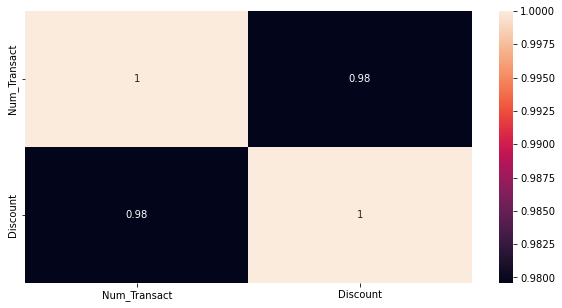

In [24]:
df_new_sales_trend_mon.corr()
corrMatrix = df_new_sales_trend_mon.corr()
plt.figure(figsize = (10,5))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()
# The number of transactions and discount are strongly correlated

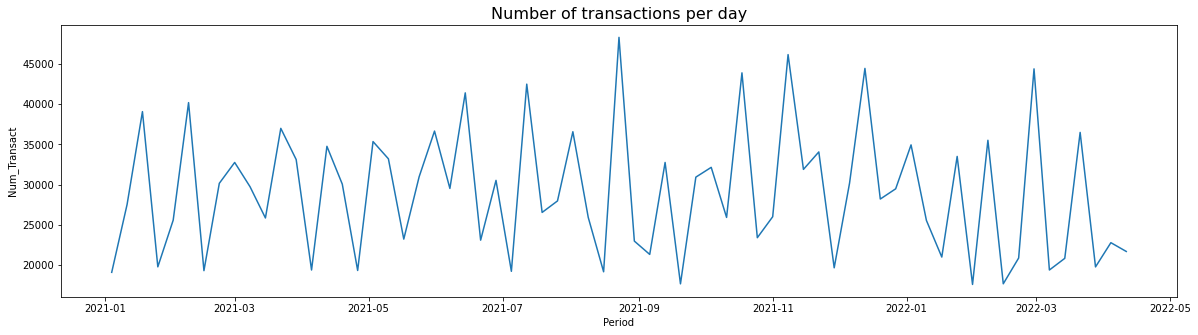

In [25]:
# no seasonality detected. continuous sales
df_new_sales_trend_period = pd.DataFrame(df_new.groupby('Period')['Num_Transact'].sum())
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_period.index, y = df_new_sales_trend_period['Num_Transact'])
plt.title("Number of transactions per day",fontsize = 16)
plt.show()

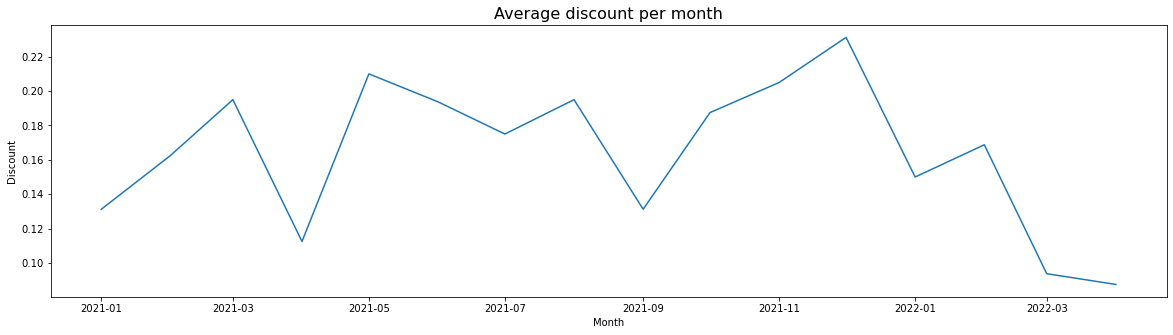

In [26]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_mon.index, y = df_new_sales_trend_mon['Discount'])
plt.title("Average discount per month",fontsize = 16)
plt.show()

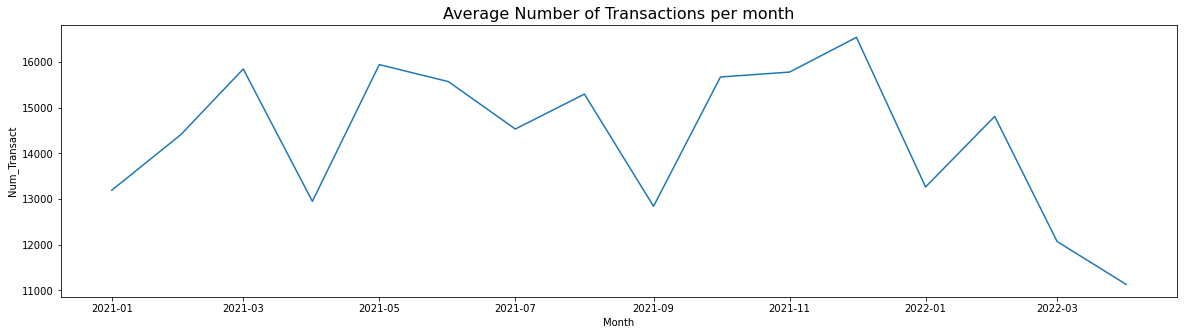

In [27]:
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_mon.index, y = df_new_sales_trend_mon['Num_Transact'])
plt.title("Average Number of Transactions per month",fontsize = 16)
plt.show()

In [108]:
df_new_sales_transac_mon = df_new_sales_trend_mon.drop(['Discount'],axis=1)

In [29]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_new_sales_transac_mon, autolag='AIC')
dftest

(-1.3554034757303726,
 0.6034598496663112,
 5,
 10,
 {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487},
 161.227029137431)

In [110]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_new_sales_transac_mon, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.355403
p-value                         0.603460
#Lags Used                      5.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary.

In other words, it has some time-dependent structure and does not have constant variance over time.

###### Conclusion: the number of transactions decreases or increases in the same trend as discount rate.

The seasonality is strongly linked to discount. It's a continuous sales depending on discount rate.

if we say shampoo has seasonality then the seasonality is invoked by promotion events.

if we disregard the discount factor then shampoo sales has no seasonality.

###### 4.What is the cost per unit of each product?

In [31]:
pantene_cost = df_Pantene['Cost'][0]
df_new.groupby('Product')['Cost'].mean()
# Cost of Aussie is $2.8 each
# Cost of Pantene is $4.1 each

Product
Aussie     2.798734
Pantene    4.100000
Name: Cost, dtype: float64

In [32]:
Aussie_cost = df_new.groupby('Product')['Cost'].mean().values[0]
print('Cost of Aussie is: ',Aussie_cost)
Pantene_cost = df_new.groupby('Product')['Cost'].mean().values[1]
print('Cost of Pantene is: ',Pantene_cost)

Cost of Aussie is:  2.7987341535084607
Cost of Pantene is:  4.1


In [33]:
Pantene_orginal_price = df_Pantene.query("Discount==0")['Price'].mean()
Pantene_margin = Pantene_orginal_price - pantene_cost 
print('Pantene_margin is {}:'.format(Pantene_margin))

Pantene_margin is 3.8900000000000032:


In [34]:
Aussie_orignal_price = df_Aussie.query("Discount==0")['Price'].mean()
Aussie_cost = df_Aussie['Cost'].mean()
Aussie_margin = Aussie_orignal_price - Aussie_cost
print('Aussie_margin is {}:'.format(Aussie_margin))

Aussie_margin is 2.1912658464915364:


###### 5.How would Pantene perform for units, sales and margin with a 25% discount?¶
###### 6.How would Pantene perform for units, sales and margin with a 60% discount?


Step1: calculate profit % = profit/sales = (price – cost)/price at 25% discount and at 60% discount
Pantene price = 7.99, cost = 4.1, profit = 3.89
The profit rate at 25% is 32%. The profit rate at 60% is -28%

Step2 - Linear Regression approach to calculate 25% and 60% units, sales and margin

- Use linear regression to project number of transactions based on discount rate,
  since correlation 0.98 between discount and number of transactions.
    
- Use the closet sales/transaction to get sales per transaction at 25% and 60%

- sales = sales per transactions x number of transactions

- units = sales/price

- use profit rate to calculate gross margin based on sales dollar


In [35]:
pantene_25_price = Pantene_orginal_price*(1-0.25)
pantene_25_profit_percentage = (pantene_25_price-pantene_cost)/pantene_25_price
print('Pantene profit divided by sales at 25% discount is {}:'.format(pantene_25_profit_percentage))

Pantene profit divided by sales at 25% discount is 0.3158114309553612:


In [36]:
pantene_60_price = Pantene_orginal_price*(1-0.6)
pantene_60_profit_percentage = (pantene_60_price-pantene_cost)/pantene_60_price
print('Pantene profit divided by sales at 60% discount is {}:'.format(pantene_60_profit_percentage))

Pantene profit divided by sales at 60% discount is -0.2828535669586977:


In [37]:
df_Pantene_mon = df_new.query("Product == 'Pantene'")

In [38]:
df_Pantene_mon1 = df_Pantene_mon.groupby('Month')['Discount','Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean()
df_Pantene_mon1.corr()
# Sales and Units are strongly correlated
# Sales and Num of transactions are strongly correlated

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/616198269.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_Pantene_mon1 = df_Pantene_mon.groupby('Month')['Discount','Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean()


,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
Discount,1.000000,0.754514,0.808107,-0.445379,0.920812,-0.287596
Units,0.754514,1.000000,0.990421,-0.873982,0.891440,0.393488
Sales $,0.808107,0.990421,1.000000,-0.798510,0.939517,0.299534
Gross Margin $,-0.445379,-0.873982,-0.798510,1.000000,-0.579848,-0.661303
Num_Transact,0.920812,0.891440,0.939517,-0.579848,1.000000,-0.024856
Sales/Transact,-0.287596,0.393488,0.299534,-0.661303,-0.024856,1.000000


In [39]:
df_Pantene_unit_sales_margin_0 = df_Pantene.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean()
df_Pantene_unit_sales_margin_1 = df_Pantene_unit_sales_margin_0.reset_index()
df_Pantene_unit_sales_margin_1

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/1613724445.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_Pantene_unit_sales_margin_0 = df_Pantene.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean()


,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
0,0.00,8636.214286,69003.352143,33594.873571,8396.392857,8.218387
1,0.05,9371.000000,70188.790000,31767.690000,9127.333333,7.689710
2,0.10,10183.000000,74234.070000,32483.770000,9983.000000,7.436048
3,0.15,12882.571429,87472.660000,34654.117143,11833.428571,7.394484
4,0.20,14238.666667,92408.946667,34030.413333,12609.666667,7.329036
5,0.30,20619.428571,113200.662857,28661.005714,16590.571429,6.823363
6,0.35,27942.000000,147813.180000,33250.980000,21494.000000,6.876951
7,0.40,32604.600000,156176.034000,22497.174000,22379.400000,6.978616
8,0.45,41056.333333,184342.936667,16011.970000,23154.666667,7.963820
9,0.50,56170.875000,224121.791250,-6178.796250,25998.125000,8.619854


In [40]:
df_Pantene_unit_sales_margin_1.corr()
# Discounts and Num of transactions are strongly correlated
# Sales and Num of transactions are strongly correlated
# Sales and Units are strongly correlated

,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
Discount,1.000000,0.934296,0.956357,-0.743721,0.985034,0.010210
Units,0.934296,1.000000,0.995352,-0.914651,0.950200,0.345509
Sales $,0.956357,0.995352,1.000000,-0.871470,0.973345,0.275456
Gross Margin $,-0.743721,-0.914651,-0.871470,1.000000,-0.753406,-0.603341
Num_Transact,0.985034,0.950200,0.973345,-0.753406,1.000000,0.055343
Sales/Transact,0.010210,0.345509,0.275456,-0.603341,0.055343,1.000000


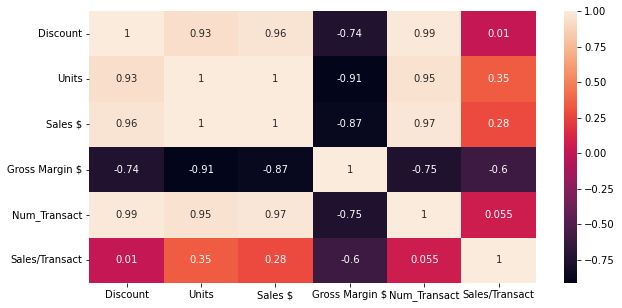

In [41]:
corrMatrix_unit_sales_margin = df_Pantene_unit_sales_margin_1.corr()
plt.figure(figsize = (10,5))
ax=(sns.heatmap(corrMatrix_unit_sales_margin, annot=True))
plt.show()

In [42]:
from sklearn.linear_model import LinearRegression
x= np.array(df_Pantene_unit_sales_margin_1['Discount'].to_list()).reshape((-1, 1))
y = df_Pantene_unit_sales_margin_1['Num_Transact'].to_list()

In [43]:
# determine the linear regression between discounts and number of transactions
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.9702917248796774
intercept: 6856.238376623371
slope: [37201.68030303]


In [44]:
# predict the number of transactions when the discounts are at 25% and 60%
x_new = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.60]).reshape((-1, 1))
y_num_transactions = model.predict(x_new)
print('predicted average number of transactions at 25%:', y_num_transactions[5])
print('predicted average number of transactions at 60%:', y_num_transactions[-1])

predicted average number of transactions at 25%: 16156.658452380952
predicted average number of transactions at 60%: 29177.24655844157


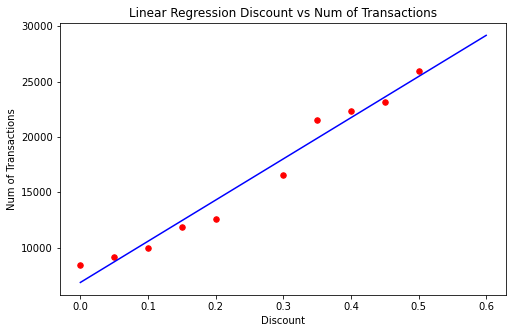

In [45]:
plt.figure(figsize = (8,5))
plt.scatter(x,y,color = 'r',marker = 'o', s= 30)
plt.plot(x_new,y_num_transactions,color = 'b')
plt.xlabel('Discount') 
plt.ylabel('Num of Transactions')
plt.title('Linear Regression Discount vs Num of Transactions')
plt.show()

In [46]:
# df_Pantene_unit_sales_margin_1.loc[len(df_Pantene_unit_sales_margin_1.index)] = [0.25,'NaN','NaN','NaN',y_num_transactions[5],'NaN']
# df_Pantene_unit_sales_margin_1.loc[len(df_Pantene_unit_sales_margin_1.index)] = [0.60,'NaN','NaN','NaN',y_num_transactions[-1],'NaN']

In [47]:
X = sm.add_constant(df_Pantene_unit_sales_margin_1['Discount'].values)
Model = sm.OLS(df_Pantene_unit_sales_margin_1['Num_Transact'].values, X).fit()
print(Model.summary())
# P-value less than 0.05, reject the null hypothesis, number of transactions and discounts has a strong correlation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     261.3
Date:                Wed, 04 Jan 2023   Prob (F-statistic):           2.16e-07
Time:                        19:11:17   Log-Likelihood:                -84.032
No. Observations:                  10   AIC:                             172.1
Df Residuals:                       8   BIC:                             172.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6856.2384    690.441      9.930      0.0

C:\Users\nim\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [48]:
df_Pantene_unit_sales_margin_1

,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
0,0.00,8636.214286,69003.352143,33594.873571,8396.392857,8.218387
1,0.05,9371.000000,70188.790000,31767.690000,9127.333333,7.689710
2,0.10,10183.000000,74234.070000,32483.770000,9983.000000,7.436048
3,0.15,12882.571429,87472.660000,34654.117143,11833.428571,7.394484
4,0.20,14238.666667,92408.946667,34030.413333,12609.666667,7.329036
5,0.30,20619.428571,113200.662857,28661.005714,16590.571429,6.823363
6,0.35,27942.000000,147813.180000,33250.980000,21494.000000,6.876951
7,0.40,32604.600000,156176.034000,22497.174000,22379.400000,6.978616
8,0.45,41056.333333,184342.936667,16011.970000,23154.666667,7.963820
9,0.50,56170.875000,224121.791250,-6178.796250,25998.125000,8.619854


In [49]:
# sales/transaction does not have correlation with any other element so we can just use the closest value to calculate. 
# In this case, use the sales per transaction at 30% discount makes more sense.
sales_25_Pantene = df_Pantene_unit_sales_margin_1['Sales/Transact'][5] *  y_num_transactions[5]
print('Avg sales $ for Pantene at 25% discount is: ',sales_25_Pantene)

Avg sales $ for Pantene at 25% discount is:  110242.73873619428


In [50]:
# sales/transaction does not have correlation with any other element so we can just use the closest value to calculate. 
# In this case, use the sales per transaction at 50% discount.
sales_60_Pantene = df_Pantene_unit_sales_margin_1['Sales/Transact'][9] * y_num_transactions[-1]
print('Avg sales $ for Pantene at 60% discount is: ',sales_60_Pantene)

Avg sales $ for Pantene at 60% discount is:  251503.60661320193


In [51]:
margin_25_Pantene = sales_25_Pantene * pantene_25_profit_percentage
margin_60_Pantene = sales_60_Pantene * pantene_60_profit_percentage
print('Avg Gross Margin $ for Pantene at 25% discount is: ',margin_25_Pantene)
print('Avg Gross Margin $ for Pantene at 60% discount is: ',margin_60_Pantene)

Avg Gross Margin $ for Pantene at 25% discount is:  34815.91707271554
Avg Gross Margin $ for Pantene at 60% discount is:  -71138.69223352127


In [52]:
Pantene_orginal_price = float(df_Pantene.query("Discount == 0")['Price'].unique())

In [53]:
unit_25_Pantene = sales_25_Pantene/(Pantene_orginal_price*0.75)
print("Pantene avg units sold at 25% discount is: ",unit_25_Pantene)
unit_60_Pantene = sales_60_Pantene/(Pantene_orginal_price*0.40)
print("Pantene avg units sold at 60% discount is: ",unit_60_Pantene)

Pantene avg units sold at 25% discount is:  18396.78577158019
Pantene avg units sold at 60% discount is:  78693.24362115204


In [54]:
dict_25 = {'Discount':[0.25],'Units':[unit_25_Pantene],'Sales $':[sales_25_Pantene],'Gross Margin $':[margin_25_Pantene],'Num_Transact':[y_num_transactions[5]],'Sales/Transact':[df_Pantene_unit_sales_margin_1['Sales/Transact'][5]]}
df_Pantene_unit_sales_margin_25 = pd.DataFrame(dict_25)
dict_60 = {'Discount':[0.60],'Units':[unit_60_Pantene],'Sales $':[sales_60_Pantene],'Gross Margin $':[margin_60_Pantene],'Num_Transact':[y_num_transactions[-1]],'Sales/Transact':[df_Pantene_unit_sales_margin_1['Sales/Transact'][9]]}
df_Pantene_unit_sales_margin_60 = pd.DataFrame(dict_60)
df_Pantene_unit_sales_margin_25

,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
0,0.25,18396.785772,110242.738736,34815.917073,16156.658452,6.823363


In [55]:
df_Pantene_unit_sales_margin_2 = df_Pantene_unit_sales_margin_1.append(df_Pantene_unit_sales_margin_25, ignore_index = True)
df_Pantene_unit_sales_margin_3 = df_Pantene_unit_sales_margin_2.append(df_Pantene_unit_sales_margin_60,ignore_index = True)
df_Pantene_unit_sales_margin_3['Sequence'] = [1,2,3,4,5,7,8,9,10,11,6,12]
df_Pantene_unit_sales_margin_4 = df_Pantene_unit_sales_margin_3.sort_values('Sequence')
df_Pantene_unit_sales_margin_5 = df_Pantene_unit_sales_margin_4.set_index('Sequence')

df_Pantene_unit_sales_margin_6 = df_Pantene_unit_sales_margin_5.rename(columns ={'Units':'Avg_Units','Sales $':'Avg_Sales','Gross Margin $':'Avg_Margin','Num_Transact':'Avg_Num_Transact','Sales/Transact':'Avg_Sales/Transact'})
df_Pantene_unit_sales_margin_6

,Discount,Avg_Units,Avg_Sales,Avg_Margin,Avg_Num_Transact,Avg_Sales/Transact
Sequence,,,,,,
1,0.00,8636.214286,69003.352143,33594.873571,8396.392857,8.218387
2,0.05,9371.000000,70188.790000,31767.690000,9127.333333,7.689710
3,0.10,10183.000000,74234.070000,32483.770000,9983.000000,7.436048
4,0.15,12882.571429,87472.660000,34654.117143,11833.428571,7.394484
5,0.20,14238.666667,92408.946667,34030.413333,12609.666667,7.329036
6,0.25,18396.785772,110242.738736,34815.917073,16156.658452,6.823363
7,0.30,20619.428571,113200.662857,28661.005714,16590.571429,6.823363
8,0.35,27942.000000,147813.180000,33250.980000,21494.000000,6.876951
9,0.40,32604.600000,156176.034000,22497.174000,22379.400000,6.978616


###### Overview of Linear Regression approach

In [56]:
# Try linear regression to calculate average sales units.
x1= np.array(df_Pantene_unit_sales_margin_1['Num_Transact'].to_list()).reshape((-1, 1))
y1 = df_Pantene_unit_sales_margin_1['Sales $'].to_list()

In [57]:
model.fit(x1, y1)
model = LinearRegression().fit(x1, y1)
r_sq = model.score(x1, y1)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.9474008590494659
intercept: -6309.475143329459
slope: [7.93516295]


In [58]:
list_num_transaction_0= df_Pantene_unit_sales_margin_1['Num_Transact'].to_list()
list_num_transaction_0.insert(5,y_num_transactions[5])
list_num_transaction_0.append(y_num_transactions[-1])
print(list_num_transaction_0)

[8396.392857142857, 9127.333333333334, 9983.0, 11833.42857142857, 12609.666666666666, 16156.658452380952, 16590.571428571428, 21494.0, 22379.4, 23154.666666666668, 25998.125, 29177.24655844157]


In [59]:
x_new_1 = np.array(list_num_transaction_0).reshape((-1, 1))
y_sales_dollar = model.predict(x_new_1)
print('predicted average sales $ at 25%:', y_sales_dollar[5])
print('predicted average sales $ at 60%:', y_sales_dollar[-1])

predicted average sales $ at 25%: 121896.24235833334
predicted average sales $ at 60%: 225216.73064810818


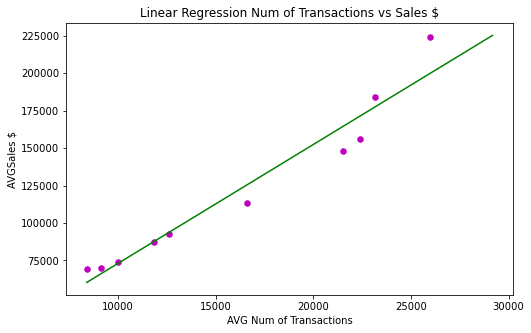

In [60]:
plt.figure(figsize = (8,5))
plt.scatter(x1,y1,color = 'm',marker = 'o', s= 30)
plt.plot(x_new_1,y_sales_dollar,color = 'g')
plt.xlabel('AVG Num of Transactions') 
plt.ylabel('AVGSales $')
plt.title('Linear Regression Num of Transactions vs Sales $')
plt.show()

Use linear regression to project sales from number of transactions is not ideal. we'll abandon this approach

###### 7.What impact does being “On Flyer” have on performance?

On flyer can increase sales units and number of transactions but reduce gross margins

In [61]:
df_new_onflyer = df_new.groupby('On Flyer?')['Units','Sales $','Gross Margin $'].sum()
df_new_onflyer

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/1344346986.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_onflyer = df_new.groupby('On Flyer?')['Units','Sales $','Gross Margin $'].sum()


,Units,Sales $,Gross Margin $
On Flyer?,,,
No,861550,4720937.1,1.883077e+06
Yes,2150150,8743937.7,1.396930e+06


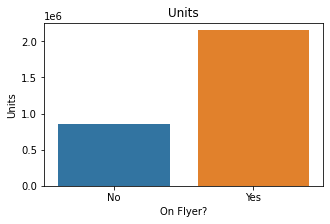

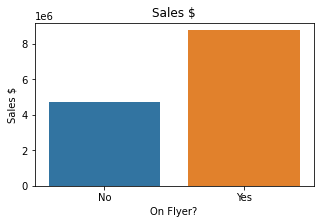

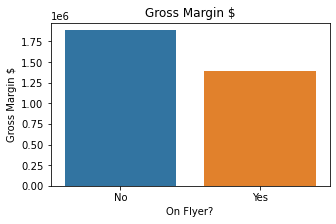

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
list_attribute = ['Units','Sales $','Gross Margin $']
for v in list_attribute:
    plt.figure(figsize = (5,3))
    sns.barplot(x=df_new_onflyer.index,y = v, data =df_new_onflyer)
    plt.title(v)
    plt.show()

###### 8.	Client wants to change the price on an upcoming Aussie Shampoo flyer promotion. Her goal is to maximize sales, but she does not want to sacrifice too much margin.

In [63]:
df_new_top_sales1 = df_new.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean().reset_index()
df_new_top_sales1

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/1221449656.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_top_sales1 = df_new.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean().reset_index()


,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
0,0.00,9792.719298,61592.721930,28658.051754,9499.789474,6.659042,3.116209
1,0.05,9910.500000,66447.570000,29561.445000,9671.250000,6.988726,3.117739
2,0.10,11406.500000,65471.385000,26911.858614,10618.500000,6.237515,2.575059
3,0.15,13946.916667,78619.355833,29908.293126,12166.083333,6.497824,2.476214
4,0.20,20172.545455,90196.638182,28665.256364,15488.181818,5.928078,1.907968
5,0.30,29073.875000,119509.823750,26375.673750,18594.250000,6.464869,1.443774
6,0.35,42366.444444,151804.268889,25106.091111,20670.777778,7.354227,1.211480
7,0.40,45962.090909,164103.142727,16142.933636,22326.000000,7.351316,0.722510
8,0.45,41056.333333,184342.936667,16011.970000,23154.666667,7.963820,0.691735
9,0.50,58507.444444,220578.036667,-8151.374444,25597.888889,8.615775,-0.329967


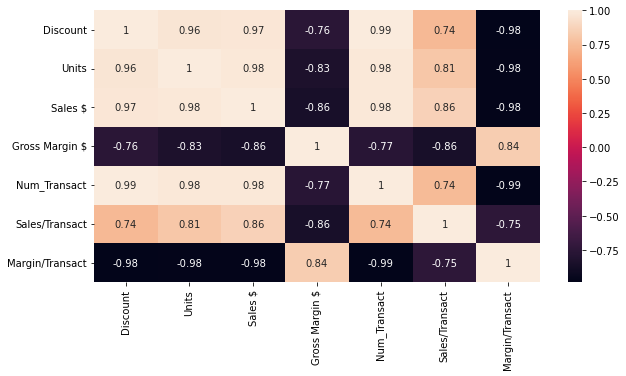

In [64]:
corrMatrix = df_new_top_sales1.corr()
plt.figure(figsize = (10,5))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/1113507420.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_Aussie_45_project0 = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean().reset_index()


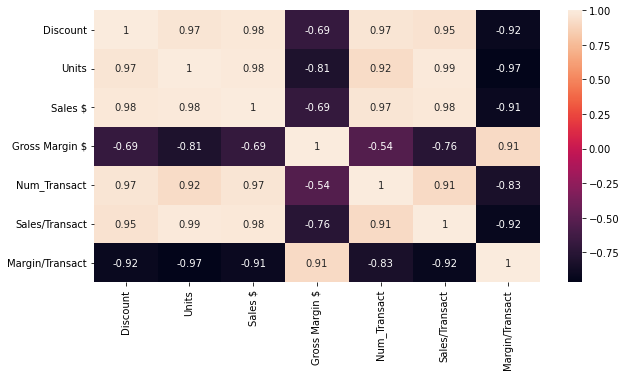

In [65]:
#Check the correlation to see Aussie's margin at 45% discount
df_Aussie_45_project0 = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean().reset_index()
corrMatrix = df_Aussie_45_project0.corr()
plt.figure(figsize = (10,5))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()

In [66]:
df_Aussie_45_project0

,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
0,0.00,10909.344828,54437.630690,23891.465172,10565.137931,5.153468,2.261742
1,0.05,11529.000000,55223.910000,22942.710000,11303.000000,4.885775,2.029789
2,0.10,12630.000000,56708.700000,21339.947228,11254.000000,5.038982,1.896210
3,0.15,15437.000000,66224.730000,23264.139503,12631.800000,5.242500,1.841642
4,0.20,22397.750000,89367.022500,26653.322500,16567.625000,5.402718,1.611337
5,0.30,35649.555556,124416.948889,24598.193333,20152.666667,6.186040,1.223028
6,0.35,46487.714286,152944.580000,22778.980000,20435.571429,7.490591,1.115620
7,0.40,57093.333333,170709.066667,10847.733333,22281.500000,7.661899,0.486877
8,0.50,77200.000000,192228.000000,-23932.000000,22396.000000,8.583140,-1.068584


In [67]:
x2= np.array(df_Aussie_45_project0['Discount'].to_list()).reshape((-1, 1))
y2 = df_Aussie_45_project0['Sales $'].to_list()

In [68]:
model.fit(x2, y2)
model = LinearRegression().fit(x2, y2)
r_sq = model.score(x2, y2)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.9576177206098813
intercept: 35478.14375491621
slope: [313637.70485413]


In [69]:
list_discount_0= df_Aussie_45_project0['Discount'].to_list()
list_discount_0.insert(8,0.45)
print(list_discount_0)

[0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5]


In [70]:
x_new_2 = np.array(list_discount_0).reshape((-1, 1))
y_sales_dollar_Aussie = model.predict(x_new_2)
print('predicted average sales $ at 45%:', y_sales_dollar_Aussie [8])

predicted average sales $ at 45%: 176615.1109392744


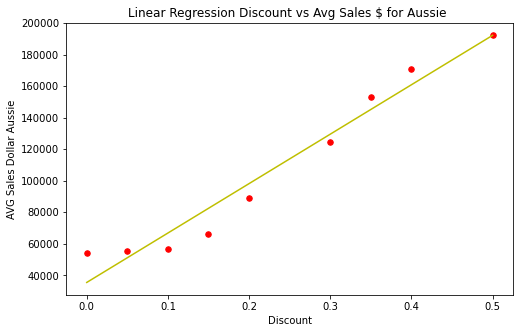

In [71]:
plt.figure(figsize = (8,5))
plt.scatter(x2,y2,color = 'r',marker = 'o', s= 30)
plt.plot(x_new_2,y_sales_dollar_Aussie,color = 'y')
plt.xlabel('Discount') 
plt.ylabel('AVG Sales Dollar Aussie')
plt.title('Linear Regression Discount vs Avg Sales $ for Aussie ')
plt.show()

In [72]:
Aussie_original_price = float(df_Aussie.query("Discount == 0")['Price'].unique())
Aussie_units_45 = y_sales_dollar_Aussie[8]/(Aussie_original_price*(1-0.45))
print('Aussie units sold at 45% discount is: ',Aussie_units_45)

Aussie units sold at 45% discount is:  64352.381468126936


In [73]:
Aussie_profit_45_percent = (Aussie_original_price*(1-0.45)-Aussie_cost)/(Aussie_original_price*(1-0.45))
Aussie_profit_45 = y_sales_dollar_Aussie [8] * Aussie_profit_45_percent
print('Aussie gross margin at 45% discount is: ',Aussie_profit_45)

Aussie gross margin at 45% discount is:  -3490.0969351775334


In [74]:
dict_Aussie_45 = {'Discount':[0.45],'Units':[Aussie_units_45],'Sales $':[y_sales_dollar_Aussie [8]],'Gross Margin $':[Aussie_profit_45]}
df_Aussie_45 = pd.DataFrame(dict_Aussie_45)
df_Aussie_45

,Discount,Units,Sales $,Gross Margin $
0,0.45,64352.381468,176615.110939,-3490.096935


In [75]:
df_new_top_sales_45 = df_new_top_sales1.query("Discount == 0.45").drop(['Num_Transact','Sales/Transact','Margin/Transact'],axis = 1)
df_new_top_sales_45

,Discount,Units,Sales $,Gross Margin $
8,0.45,41056.333333,184342.936667,16011.97


In [76]:
dict_both_45 = {'Discount':[0.45],'Units':[float(df_new_top_sales_45['Units'].values)+ Aussie_units_45],'Sales $':[float(df_new_top_sales_45['Sales $'].values)+y_sales_dollar_Aussie [8]],'Gross Margin $':[float(df_new_top_sales_45['Gross Margin $'].values)+Aussie_profit_45]}
df_both_45_final = pd.DataFrame(dict_both_45)
df_both_45_final
# combined numbers with Pantene at 45% and Aussie at 45%

,Discount,Units,Sales $,Gross Margin $
0,0.45,105408.714801,360958.047606,12521.873065


In [77]:
df_new_top_sales2 = df_new_top_sales1.sort_values('Sales $',ascending=False)
df_new_top_sales3 = df_new_top_sales2.head(1)
df_new_top_sales4 = df_new_top_sales3.groupby('Discount')['Sales $','Gross Margin $'].mean()
df_new_top_sales4 

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/3465215372.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_top_sales4 = df_new_top_sales3.groupby('Discount')['Sales $','Gross Margin $'].mean()


,Sales $,Gross Margin $
Discount,,
0.5,220578.036667,-8151.374444


In [78]:
df_new_50_Pantene_0 = df_new.query("Discount==0.5").drop(index = 105,axis= 0) # drop the record of Aussie at 50% discount
df_new_50_Pantene = df_new_50_Pantene_0.groupby('Discount')['Units','Sales $','Gross Margin $'].mean()
df_new_50_Pantene

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/1105616482.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_50_Pantene = df_new_50_Pantene_0.groupby('Discount')['Units','Sales $','Gross Margin $'].mean()


,Units,Sales $,Gross Margin $
Discount,,,
0.5,56170.875,224121.79125,-6178.79625


In [79]:
margin = float(df_new_50_Pantene['Gross Margin $'].values)
print(margin)

-6178.7962499999685


In [80]:
df_Aussie_right_discount = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $'].mean()
df_Aussie_right_discount1 = df_Aussie_right_discount.sort_values('Sales $',ascending = False).query("`Gross Margin $`>=@margin")
df_Aussie_right_discount2 = df_Aussie_right_discount1.head(1)
df_Aussie_right_discount2

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/513937264.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_Aussie_right_discount = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $'].mean()


,Units,Sales $,Gross Margin $
Discount,,,
0.4,57093.333333,170709.066667,10847.733333


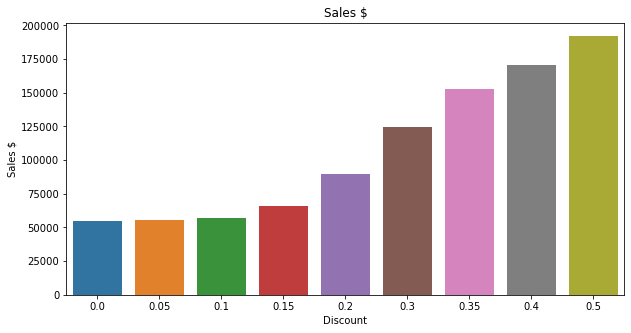

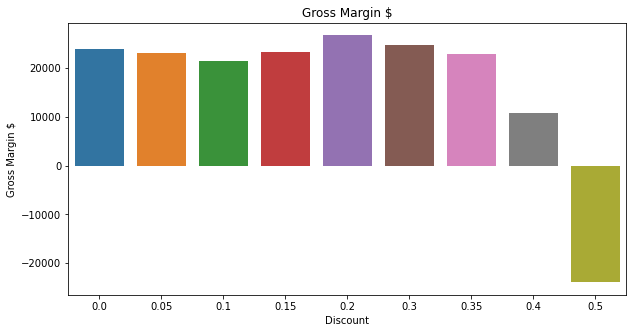

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
list_attribute = ['Sales $','Gross Margin $']
for v in list_attribute:
    plt.figure(figsize = (10,5))
    sns.barplot(x=df_Aussie_right_discount.index,y = v, data =df_Aussie_right_discount)
    plt.title(v)
    plt.show()

Pantene at 50% discount and Aussie at 40% discount can have the maximum sales, 
at the same time Aussie's margin can cover the negative margin from Pantene discounted at 50%

In [82]:
df_new_top_sales_final = df_new_50_Pantene.add(df_Aussie_right_discount2, fill_value=0)
df_new_top_sales_final 

,Units,Sales $,Gross Margin $
Discount,,,
0.4,57093.333333,170709.066667,10847.733333
0.5,56170.875000,224121.791250,-6178.796250


In [83]:
print('Total average maximum units when Pantene at 50% and Aussie at 40%:  ', df_new_top_sales_final['Units'].values[0]+ df_new_top_sales_final['Units'].values[1])
print('Total average maximum sales when Pantene at 50% and Aussie at 40%:  ', df_new_top_sales_final['Sales $'].values[0]+ df_new_top_sales_final['Sales $'].values[1])
print('Total average maximum gross margin when Pantene at 50% and Aussie at 40%:  ', df_new_top_sales_final['Gross Margin $'].values[0]+ df_new_top_sales_final['Gross Margin $'].values[1])

Total average maximum units when Pantene at 50% and Aussie at 40%:   113264.20833333334
Total average maximum sales when Pantene at 50% and Aussie at 40%:   394830.85791666666
Total average maximum gross margin when Pantene at 50% and Aussie at 40%:   4668.937083333378


In [84]:
dict_40_50 = {'Discount':['0.4-0.5'],'Units':[df_new_top_sales_final['Units'].values[0]+ df_new_top_sales_final['Units'].values[1]],'Sales $':[df_new_top_sales_final['Sales $'].values[0]+ df_new_top_sales_final['Sales $'].values[1]],'Gross Margin $':[df_new_top_sales_final['Gross Margin $'].values[0]+ df_new_top_sales_final['Gross Margin $'].values[1]]}
df_Pantene_50_Aussie_40 = pd.DataFrame(dict_40_50)
df_Pantene_50_Aussie_40

,Discount,Units,Sales $,Gross Margin $
0,0.4-0.5,113264.208333,394830.857917,4668.937083


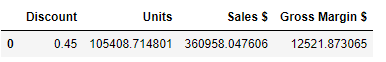

Comparing with the result that Pantene and Aussie both sold at 45% discount:

- The sales with Pantene sold at 50% and Aussie at 40% is 30,000 higher.
- Gross margin with Pantene sold at 50% and Aussie at 40% is lower, but still $ 4668 which is still positive.

Conclusion: To maximize sales and not sacrifice margin, we should choose Pantene sold at 50% and Aussie at 40%

In [85]:
# price = df_Aussie.query("Discount==0.4")['Price'].mean()
# description = "Price of Aussie at 40% discount is at: "
# print(f'{description}{price}')

In [86]:
df_max_sales_Pantene = df_Pantene.groupby(['Price','Discount'])['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean().reset_index()
df_max_sales_Pantene

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/3574190065.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_max_sales_Pantene = df_Pantene.groupby(['Price','Discount'])['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean().reset_index()


,Price,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
0,3.99,0.50,56170.875000,224121.791250,-6178.796250,25998.125000,8.619854
1,4.49,0.45,41056.333333,184342.936667,16011.970000,23154.666667,7.963820
2,4.79,0.40,32604.600000,156176.034000,22497.174000,22379.400000,6.978616
3,5.29,0.35,27942.000000,147813.180000,33250.980000,21494.000000,6.876951
4,5.49,0.30,20619.428571,113200.662857,28661.005714,16590.571429,6.823363
5,6.49,0.20,14238.666667,92408.946667,34030.413333,12609.666667,7.329036
6,6.79,0.15,12882.571429,87472.660000,34654.117143,11833.428571,7.394484
7,7.29,0.10,10183.000000,74234.070000,32483.770000,9983.000000,7.436048
8,7.49,0.05,9371.000000,70188.790000,31767.690000,9127.333333,7.689710
9,7.99,0.00,8636.214286,69003.352143,33594.873571,8396.392857,8.218387


In [87]:
minimum_margin_Aussie = df_max_sales_Pantene['Gross Margin $'].values[0]
minimum_margin_Aussie
# for Aussie, we need to find a price point that can cover the negative margin when selling Pantene at 50% discount which generates maximum sales
# Aussie is at negative margin when sold at 45%. so it has to be higher than 45% and lower than 40%

-6178.7962499999685

In [88]:
df_max_sales_Aussie = df_Aussie.groupby(['Price','Discount'])['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean().reset_index()
df_max_sales_Aussie

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/3749224345.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_max_sales_Aussie = df_Aussie.groupby(['Price','Discount'])['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact'].mean().reset_index()


,Price,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
0,2.49,0.50,77200.000000,192228.000000,-23932.000000,22396.000000,8.583140
1,2.99,0.40,57093.333333,170709.066667,10847.733333,22281.500000,7.661899
2,3.29,0.35,46487.714286,152944.580000,22778.980000,20435.571429,7.490591
3,3.49,0.30,35649.555556,124416.948889,24598.193333,20152.666667,6.186040
4,3.99,0.20,22397.750000,89367.022500,26653.322500,16567.625000,5.402718
5,4.29,0.15,15437.000000,66224.730000,23264.139503,12631.800000,5.242500
6,4.49,0.10,12630.000000,56708.700000,21339.947228,11254.000000,5.038982
7,4.79,0.05,11529.000000,55223.910000,22942.710000,11303.000000,4.885775
8,4.99,0.00,10909.344828,54437.630690,23891.465172,10565.137931,5.153468


In [89]:
df_max_sales_Aussie.corr()

,Price,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact
Price,1.000000,-0.999588,-0.967572,-0.978787,0.690641,-0.967668,-0.946785
Discount,-0.999588,1.000000,0.966432,0.978579,-0.686530,0.966588,0.947688
Units,-0.967572,0.966432,1.000000,0.984752,-0.805665,0.922255,0.986454
Sales $,-0.978787,0.978579,0.984752,1.000000,-0.690333,0.968551,0.982990
Gross Margin $,0.690641,-0.686530,-0.805665,-0.690333,1.000000,-0.537491,-0.755260
Num_Transact,-0.967668,0.966588,0.922255,0.968551,-0.537491,1.000000,0.908428
Sales/Transact,-0.946785,0.947688,0.986454,0.982990,-0.755260,0.908428,1.000000


In [90]:
from sklearn.linear_model import LinearRegression
a= np.array(df_max_sales_Aussie['Price'].to_list()).reshape((-1, 1))
b = df_max_sales_Aussie['Sales $'].to_list()
model = LinearRegression()
model.fit(a, b)
model = LinearRegression().fit(a, b)
r_sq = model.score(a, b)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.9580243086276217
intercept: 348090.82347423956
slope: [-62354.40455395]


In [91]:
df_max_sales_Aussie['Price'].values
# Since Aussie at 45% is at negative margin, we'll calculate Aussie's margin at 41% discount
Aussie_price_projection = Aussie_original_price * (1-0.41)
print('Aussie projection is: ',Aussie_price_projection)

Aussie projection is:  2.9441000000000006


In [92]:
Aussie_projection_list = [2.49, Aussie_price_projection,2.99, 3.29, 3.49, 3.99, 4.29, 4.49, 4.79, 4.99]
x3_new = np.array(Aussie_projection_list).reshape((-1,1))
y_sales_Aussie = model.predict(x3_new)
print('predicted average number of transactions:', y_sales_Aussie[1])

predicted average number of transactions: 164513.22102695992


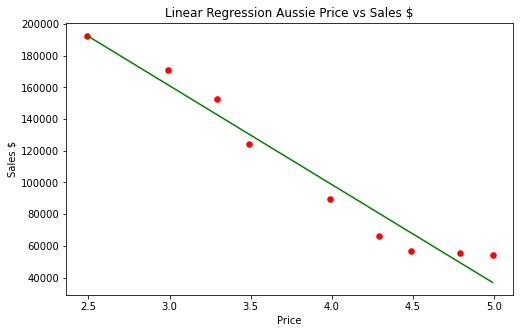

In [93]:
plt.figure(figsize = (8,5))
plt.scatter(a,b,color = 'r',marker = 'o', s= 30)
plt.plot(x3_new,y_sales_Aussie,color = 'g')
plt.xlabel('Price') 
plt.ylabel('Sales $')
plt.title('Linear Regression Aussie Price vs Sales $')
plt.show()

In [94]:
Aussie_profit_rate_projection = (Aussie_price_projection -Aussie_cost )/Aussie_price_projection
print('Aussie profit rate is: ',Aussie_profit_rate_projection)
Aussie_margin_projection = y_sales_Aussie[1] * Aussie_profit_rate_projection
print('Aussie margin at projection is:',Aussie_margin_projection)

Aussie profit rate is:  0.04937530875022509
Aussie margin at projection is: 8122.891081700168


In [95]:
# Pantene sold at 50% and Aussie at 41% total margin = 
total_margin_41_50 = Aussie_margin_projection + minimum_margin_Aussie
print('total margin when Pantene sold at 50% and Aussie at 41% is: ',total_margin_41_50)
total_sales_41_50 = y_sales_Aussie[1] + df_max_sales_Pantene['Sales $'].values[0]
print('total sales $ when Pantene sold at 50% and Aussie at 41% is: ',total_sales_41_50)

total margin when Pantene sold at 50% and Aussie at 41% is:  1944.0948317001994
total sales $ when Pantene sold at 50% and Aussie at 41% is:  388635.01227695995


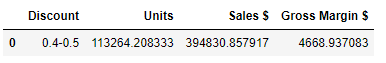

There could be deviation/discrepancy from the sales deduced from linear regression so the 41% sales is lower than 40% sales.
In common sense, we'll go with Aussie selling at 40% and Pantene selling at 50% to maximize sales while keep margin positive

###### Aussie Shampoo sold at $2.49 is a “loss leader” promotion. We lose money selling it at this price, but hope that people who came to buy it will purchase other items.

In [96]:
df_Aussie_discount = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()
df_Aussie_discount.query("Discount==0.5")

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/805475596.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_Aussie_discount = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()


,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,,,,,,
0.5,77200.0,192228.0,-23932.0,22396.0,8.58314,-1.068584


In [97]:
df_new_2 = df_new.groupby(['Discount','Product'])['Price','Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()
df_new_2.sort_values(by='Num_Transact',ascending=False)
#Aussie sold at $2.49 has number of transactions ranked the 3rd.

C:\Users\nim\AppData\Local\Temp/ipykernel_17544/4245551420.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_2 = df_new.groupby(['Discount','Product'])['Price','Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()


Price         Units        Sales $  Gross Margin $  \
Discount Product                                                       
0.50     Pantene   3.99  56170.875000  224121.791250    -6178.796250   
0.45     Pantene   4.49  41056.333333  184342.936667    16011.970000   
0.50     Aussie    2.49  77200.000000  192228.000000   -23932.000000   
0.40     Pantene   4.79  32604.600000  156176.034000    22497.174000   
         Aussie    2.99  57093.333333  170709.066667    10847.733333   
0.35     Pantene   5.29  27942.000000  147813.180000    33250.980000   
         Aussie    3.29  46487.714286  152944.580000    22778.980000   
0.30     Aussie    3.49  35649.555556  124416.948889    24598.193333   
         Pantene   5.49  20619.428571  113200.662857    28661.005714   
0.20     Aussie    3.99  22397.750000   89367.022500    26653.322500   
0.15     Aussie    4.29  15437.000000   66224.730000    23264.139503   
0.20     Pantene   6.49  14238.666667   92408.946667    34030.413333   
0.15     Pantene   6.79  12882.571429   87472.660000    34654.117143   
0.05     Aussie    4.79  11529.000000   55223.910000    22942.710000   
0.10     Aussie    4.49  12630.000000   56708.700000    21339.947228   
0.00     Aussie    4.99  10909.344828   54437.630690    23891.465172   
0.10     Pantene   7.29  10183.000000   74234.070000    32483.770000   
0.05     Pantene   7.49   9371.000000   70188.790000    31767.690000   
0.00     Pantene   7.99   8636.214286   69003.352143    33594.873571   

                  Num_Transact  Sales/Transact  Margin/Transact  
Discount Product                                                 
0.50     Pantene  25998.125000        8.619854        -0.237640  
0.45     Pantene  23154.666667        7.963820         0.691735  
0.50     Aussie   22396.000000        8.583140        -1.068584  
0.40     Pantene  22379.400000        6.978616         1.005270  
         Aussie   22281.500000        7.661899         0.486877  
0.35     Pantene  21494.000000        6.876951         1.546989  
         Aussie   20435.571429        7.490591         1.115620  
0.30     Aussie   20152.666667        6.186040         1.223028  
         Pantene  16590.571429        6.823363         1.727591  
0.20     Aussie   16567.625000        5.402718         1.611337  
0.15     Aussie   12631.800000        5.242500         1.841642  
0.20     Pantene  12609.666667        7.329036         2.698982  
0.15     Pantene  11833.428571        7.394484         2.929479  
0.05     Aussie   11303.000000        4.885775         2.029789  
0.10     Aussie   11254.000000        5.038982         1.896210  
0.00     Aussie   10565.137931        5.153468         2.261742  
0.10     Pantene   9983.000000        7.436048         3.253909  
0.05     Pantene   9127.333333        7.689710         3.480390  
0.00     Pantene   8396.392857        8.218387         4.001192

In [98]:
df_new_2.sort_values(by='Sales $',ascending=False)
#Aussie sold at $2.49 has sales ranked the 2nd

Price         Units        Sales $  Gross Margin $  \
Discount Product                                                       
0.50     Pantene   3.99  56170.875000  224121.791250    -6178.796250   
         Aussie    2.49  77200.000000  192228.000000   -23932.000000   
0.45     Pantene   4.49  41056.333333  184342.936667    16011.970000   
0.40     Aussie    2.99  57093.333333  170709.066667    10847.733333   
         Pantene   4.79  32604.600000  156176.034000    22497.174000   
0.35     Aussie    3.29  46487.714286  152944.580000    22778.980000   
         Pantene   5.29  27942.000000  147813.180000    33250.980000   
0.30     Aussie    3.49  35649.555556  124416.948889    24598.193333   
         Pantene   5.49  20619.428571  113200.662857    28661.005714   
0.20     Pantene   6.49  14238.666667   92408.946667    34030.413333   
         Aussie    3.99  22397.750000   89367.022500    26653.322500   
0.15     Pantene   6.79  12882.571429   87472.660000    34654.117143   
0.10     Pantene   7.29  10183.000000   74234.070000    32483.770000   
0.05     Pantene   7.49   9371.000000   70188.790000    31767.690000   
0.00     Pantene   7.99   8636.214286   69003.352143    33594.873571   
0.15     Aussie    4.29  15437.000000   66224.730000    23264.139503   
0.10     Aussie    4.49  12630.000000   56708.700000    21339.947228   
0.05     Aussie    4.79  11529.000000   55223.910000    22942.710000   
0.00     Aussie    4.99  10909.344828   54437.630690    23891.465172   

                  Num_Transact  Sales/Transact  Margin/Transact  
Discount Product                                                 
0.50     Pantene  25998.125000        8.619854        -0.237640  
         Aussie   22396.000000        8.583140        -1.068584  
0.45     Pantene  23154.666667        7.963820         0.691735  
0.40     Aussie   22281.500000        7.661899         0.486877  
         Pantene  22379.400000        6.978616         1.005270  
0.35     Aussie   20435.571429        7.490591         1.115620  
         Pantene  21494.000000        6.876951         1.546989  
0.30     Aussie   20152.666667        6.186040         1.223028  
         Pantene  16590.571429        6.823363         1.727591  
0.20     Pantene  12609.666667        7.329036         2.698982  
         Aussie   16567.625000        5.402718         1.611337  
0.15     Pantene  11833.428571        7.394484         2.929479  
0.10     Pantene   9983.000000        7.436048         3.253909  
0.05     Pantene   9127.333333        7.689710         3.480390  
0.00     Pantene   8396.392857        8.218387         4.001192  
0.15     Aussie   12631.800000        5.242500         1.841642  
0.10     Aussie   11254.000000        5.038982         1.896210  
0.05     Aussie   11303.000000        4.885775         2.029789  
0.00     Aussie   10565.137931        5.153468         2.261742

###### Conclusion: Aussie could very probably an effetive "loss leader" in promotion. When Aussie is on 50% discount, the margin is negative but average number of transactions is in the top 3. Furthermore, when Aussie is on 50% discount, the average sales is ranked the 2nd.

In [99]:
df_new[df_new['Sales $']==df_new['Sales $'].max()]
# 1 sales when Pantene sold at 3.99

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
11,2021,12,Pantene,3.99,Yes,0.5,58297,232605.03,-6412.67,26439,8.7978,-0.242546,4.1,2021-03-22,2021-03-01


In [100]:
df_new[df_new['Gross Margin $']==df_new['Gross Margin $'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
34,2021,35,Pantene,6.79,Yes,0.15,13246,89940.34,35631.74,12130,7.414702,2.937489,4.1,2021-08-30,2021-08-01


In [101]:
df_new[df_new['Num_Transact']==df_new['Num_Transact'].max()]
# No.1 number of transactions when Pantene sold at 3.99

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
11,2021,12,Pantene,3.99,Yes,0.5,58297,232605.03,-6412.67,26439,8.797800,-0.242546,4.1,2021-03-22,2021-03-01
49,2021,50,Pantene,3.99,Yes,0.5,56076,223743.24,-6168.36,26439,8.462621,-0.233305,4.1,2021-12-13,2021-12-01


###### Pantene at 50% discount with $3.99 is the absolute lost leader to increase sales and number of transactions

###### Your director proposes to change the promotion to 2 for $5 or pay 2.99 each, hoping that this will improve margin. Will this work? Explain why or why not.

In [102]:
df_new_2.sort_values(by='Gross Margin $',ascending=False)

,,Price,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,Product,,,,,,,
0.15,Pantene,6.79,12882.571429,87472.660000,34654.117143,11833.428571,7.394484,2.929479
0.20,Pantene,6.49,14238.666667,92408.946667,34030.413333,12609.666667,7.329036,2.698982
0.00,Pantene,7.99,8636.214286,69003.352143,33594.873571,8396.392857,8.218387,4.001192
0.35,Pantene,5.29,27942.000000,147813.180000,33250.980000,21494.000000,6.876951,1.546989
0.10,Pantene,7.29,10183.000000,74234.070000,32483.770000,9983.000000,7.436048,3.253909
0.05,Pantene,7.49,9371.000000,70188.790000,31767.690000,9127.333333,7.689710,3.480390
0.30,Pantene,5.49,20619.428571,113200.662857,28661.005714,16590.571429,6.823363,1.727591
0.20,Aussie,3.99,22397.750000,89367.022500,26653.322500,16567.625000,5.402718,1.611337
0.30,Aussie,3.49,35649.555556,124416.948889,24598.193333,20152.666667,6.186040,1.223028


When Aussie was at $2.99, the margin was listed in the bottom 3.

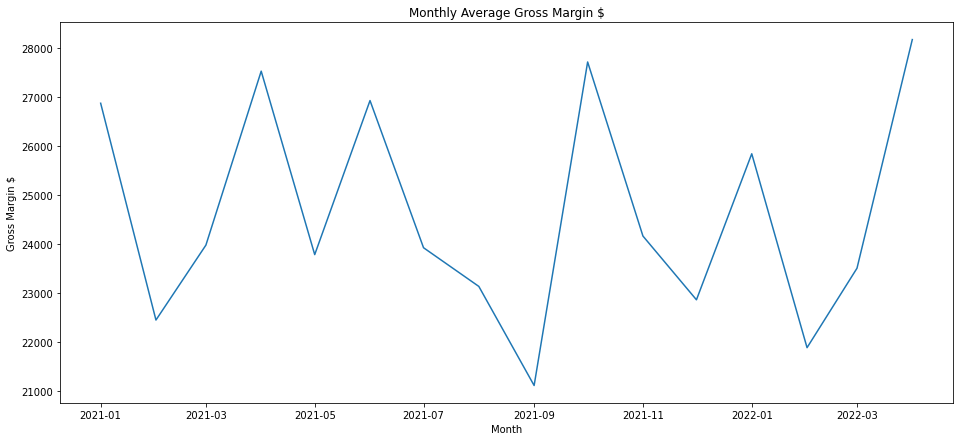

In [103]:
df_new_monthly_margin = pd.DataFrame(df_new.groupby('Month')['Gross Margin $'].mean())
plt.figure(figsize=(16,7))
sns.lineplot(x = df_new_monthly_margin.index, y = df_new_monthly_margin['Gross Margin $'])
plt.title('Monthly Average Gross Margin $')
plt.show()

In [104]:
df_new_monthly_margin[df_new_monthly_margin['Gross Margin $'] == df_new_monthly_margin['Gross Margin $'].max()]
# the best gross margin happened in April 2022.

,Gross Margin $
Month,
2022-04-01,28170.7475


In [105]:
df_new.query("Month =='2022-04-01'")

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
65,2022,14,Pantene,6.79,Yes,0.15,13118,89071.22,35287.42,12247,7.272901,2.881311,4.1,2022-04-04,2022-04-01
66,2022,15,Pantene,6.79,No,0.15,11477,77928.83,30873.13,10410,7.485959,2.965719,4.1,2022-04-11,2022-04-01
132,2022,14,Aussie,4.99,No,0.00,10767,53727.33,23579.73,10556,5.089743,2.233775,2.8,2022-04-04,2022-04-01
133,2022,15,Aussie,4.79,Yes,0.05,11529,55223.91,22942.71,11303,4.885775,2.029789,2.8,2022-04-11,2022-04-01


The maximum discount on Aussie in the month which has the highest margin is:
    
- Either no discount at $4.99 per bottle. 

- Or 5% discount at $4.79 per bottle.

In [106]:
df_Aussie_price_margin = pd.DataFrame(df_Aussie.groupby(['Discount','Price'])['Gross Margin $'].mean())
df_Aussie_price_margin2 = df_Aussie_price_margin.rename(columns ={'Gross Margin $':'Margin_avg'})
df_Aussie_price_margin3= df_Aussie_price_margin2.reset_index()
df_Aussie_price_margin3

,Discount,Price,Margin_avg
0,0.00,4.99,23891.465172
1,0.05,4.79,22942.710000
2,0.10,4.49,21339.947228
3,0.15,4.29,23264.139503
4,0.20,3.99,26653.322500
5,0.30,3.49,24598.193333
6,0.35,3.29,22778.980000
7,0.40,2.99,10847.733333
8,0.50,2.49,-23932.000000


Text(0.5, 1.0, 'Average Gross Margin of Aussie at different price')

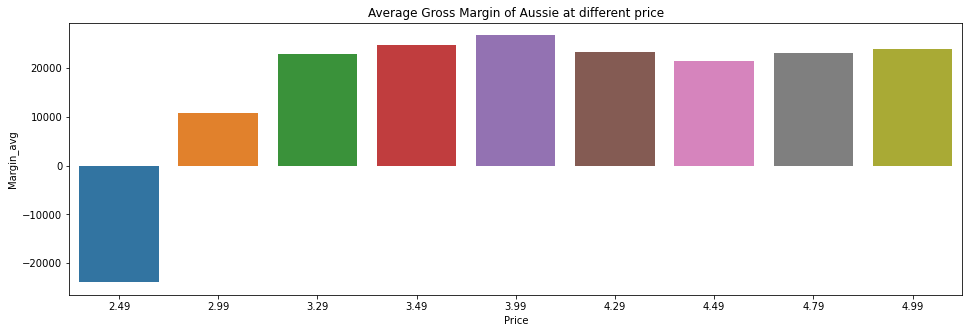

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_Aussie_price_margin3['Price'],y = 'Margin_avg', data = df_Aussie_price_margin3)
plt.title('Average Gross Margin of Aussie at different price')

###### Conclusion: The gross margin is the highest when Aussie is sold at 3.99 which is 20% discount.
When Aussie is sold at 2.99 which is 40% discount, it does not improve Margin.